In [3]:
import numpy as np
import pandas as pd
from nltk.tokenize import sent_tokenize


def tokenize_split(text):
    """simple tokeniser"""
    return text.split()


def word_chunk_transcript(transcripts, name_variable='transcript', chunk_size=500):
    """ transcripts: must have two columns - episode_id and tokenised_transcript
        chunk_size: number of tokens in chunk 
    """
    transcripts["tokenised_transcript"] = transcripts[name_variable].apply(lambda x: tokenize_split(x))

    episode_ls = []
    transcript_ls = []
    words_enum_ls = [] 
    for index, row in transcripts.iterrows():
        for i in range(0, len(row["tokenised_transcript"]), chunk_size):
            episode_ls.append(row["episode_id"])
            transcript_ls.append(" ".join(row["tokenised_transcript"][i:i+chunk_size]))
            words_enum_ls.append(f"{i+1} - {i+chunk_size}")
    word_chunked_df = pd.DataFrame(data = {'episode_id': episode_ls, 'transcript_subset':transcript_ls, 'words_enumerated':words_enum_ls})
    return word_chunked_df


def sentence_chunk_transcript(transcripts, name_variable='transcript', chunk_size=1):
    """ transcripts: must have two columns - episode_id and transcript
        chunk_size: number of sentences in chunk 
    """     
    transcripts["sentence_token"] = transcripts[name_variable].apply(lambda x: sent_tokenize(x, language='english'))
    episode_ls = []
    transcript_ls = []
    sent_enum_ls = []
    for index, row in transcripts.iterrows():
        for i in range(0, len(row["sentence_token"]), chunk_size):
            episode_ls.append(row["episode_id"])
            transcript_ls.append(" ".join(row["sentence_token"][i:i+chunk_size]))
            sent_enum_ls.append(i+1)
    sentence_chunked_df = pd.DataFrame(data = {'episode_id': episode_ls, 'transcript_subset':transcript_ls, 'sentence_enumerated':sent_enum_ls})

    return sentence_chunked_df


### Make chunked dataset

In [3]:
transcripts_sample = pd.read_csv('sports_transcripts.csv.gz', compression='gzip')
print(transcripts_sample.shape)
# transcripts_sample.head(5)

(11821, 17)


In [4]:
# Extract columns for conversion
cols_subset = transcripts_sample.loc[: ,["episode_id", "transcript"]]

### Create new datasets

In [5]:
sports_256 = word_chunk_transcript(cols_subset, name_variable='transcript', chunk_size=256)

print(sports_256.shape)
sports_256.head(2)

(368835, 3)


,episode_id,transcript_subset,words_enumerated
0,41JbXYp7c2uuJoFB4TcQtD,Hello and welcome to the law review podcast. M...,0 - 256
1,41JbXYp7c2uuJoFB4TcQtD,"as well as several other changes, so we'll get...",256 - 512


In [6]:
sports_256.to_csv('sports_word_256.csv.gz', compression='gzip')

In [7]:
sport_sent_1 = sentence_chunk_transcript(cols_subset, name_variable='transcript', chunk_size=1)
print(sport_sent_1.shape)
sport_sent_1.head(2)

(5460190, 3)


,episode_id,transcript_subset,sentence_enumerated
0,41JbXYp7c2uuJoFB4TcQtD,Hello and welcome to the law review podcast.,0 - 1
1,41JbXYp7c2uuJoFB4TcQtD,My name is Nathan Church Droid by my partner c...,1 - 2


In [8]:
sport_sent_1 = sport_sent_1.sample(500000, random_state=42)
sport_sent_1.shape

(500000, 3)

In [9]:
sport_sent_1.to_csv('sport_sent_1.csv.gz', compression='gzip')

## Annotation pipeline

In [78]:
sports_trans = pd.read_csv('sports_transcripts.csv.gz', compression='gzip', usecols=[2,3,16])
sports_trans = sports_trans.sample(200)
print(f'Average word count of annotated transcripts: {sports_trans.word_count.mean():.0f}')

Average word count of annotated transcripts: 8023


In [79]:
# Write transcripts to files
import os.path

for i in range(len(sports_trans.index)):
    save_path = '../Thesis/annotated_transcripts/'
    name_of_file = f'transcript{i+1}_{sports_trans.iloc[i,0]}'
    complete_path = os.path.join(save_path, name_of_file+".txt")

    text_file = open(complete_path, "w")
    text_file.write(sports_trans.iloc[i,1])
    text_file.close()

### Read back and output list 

In [4]:
import os
directory = '../Thesis/annotated_transcripts'

annotated_ls = []
episode_ls = []
for dirpath, dirnames, files in os.walk(directory):
    for file in files:
        episode_ls.append(file)
        path = os.path.join(dirpath, file)
        with open(path, errors='replace') as f: 
            lines = f.readlines()
            annotated_ls.append(''.join(lines))

annotated_df = pd.DataFrame({'transcript': annotated_ls, 'episode_id': episode_ls})

In [5]:
# Chunk per sentence to be able to find index of segments 
df_per_transcript = sentence_chunk_transcript(annotated_df)

# Find indicies
unique_id = df_per_transcript.episode_id.unique()

annotation_values = pd.DataFrame(columns=['episode_id', 'annotation'])

for id in unique_id:
    ids = id[:-4].split('_')
    find_annotation = df_per_transcript[df_per_transcript.episode_id == id].copy()
    annotated_index_ls = []
    for row in find_annotation.itertuples():
        if row[2].startswith('@@'):
            annotated_index_ls.append(row[3])
    if len(annotated_index_ls) != 0:
        temp_df = pd.DataFrame({'episode_id': ids[1], 'annotation':[list(annotated_index_ls)]})
        annotation_values = pd.concat([annotation_values, temp_df], axis=0)

annotation_values = annotation_values.reset_index()

print(annotation_values.shape)
print(type(annotation_values.annotation[0]))
annotation_values.head(2)

(20, 3)
<class 'list'>


,index,episode_id,annotation
0,0,4y67J0Fmgm5L7TPPsUunwo,"[18, 22, 43, 57, 71, 91, 97, 116, 155, 181, 20..."
1,0,53DrbE5nPJskpPT0PtOi9O,"[4, 8, 23, 39, 45, 55, 64, 71]"


In [12]:
# write to file to preserve all dtypes
annotation_values.to_pickle('annotations.pkl')

### Find the same transcripts, un-annotated

In [7]:
sports_trans = pd.read_csv('sports_transcripts.csv.gz', compression='gzip', usecols=[2,3,16])
annotated_transcripts_plain = sports_trans[sports_trans.episode_id.isin(annotation_values.episode_id)].copy()
print(annotated_transcripts_plain.shape)
annotated_transcripts_plain.head()
print(annotated_transcripts_plain.word_count.mean())
print(annotated_transcripts_plain.word_count.min())
annotated_transcripts_plain.word_count.max()

(20, 3)
6146.7
1205


12860

In [16]:
# EDA on annotations 
eda_ls = []
for i in range(len(annotation_values.index)):
    ls = annotation_values.iloc[i,2]
    individual_transcript_seg_size = [x - ls[i - 1] for i, x in enumerate(ls)][1:]
    eda_ls = eda_ls + individual_transcript_seg_size

print("Number of segments:", len(eda_ls))
print("Shortest segments:", min(eda_ls))
print("Longest segments:", max(eda_ls))
print("Average segment size:", round(np.mean(eda_ls),1))

Number of segments: 220
Shortest segments: 3
Longest segments: 100
Average segment size: 24.8


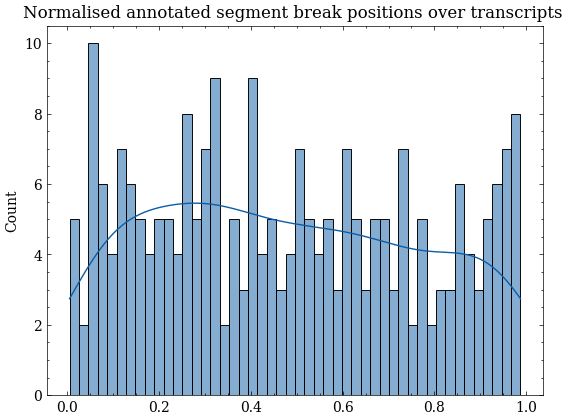

In [88]:
# EDA on annotated segmenets, plot normalised positions 
import seaborn as sns
import matplotlib.pyplot as plt 
import scienceplots

annot_lens = pd.read_csv('len_of_annotations.csv')
annot_lens = annot_lens.rename(columns = {'episode': 'episode_id'})

annotated_transcripts_plain.dtypes
plot_df = annot_lens.merge(annotation_values, on='episode_id', how='inner')

norm_ls = []
for i in range(len(plot_df.index)):
    ls = plot_df.iloc[i,4]
    length = plot_df.iloc[i,2]
    norm_ls_small = []
    for element in ls:
        norm_ls_small.append(element/length)

    norm_ls = norm_ls + norm_ls_small

plt.style.use(['science','no-latex'])
plt.rcParams["figure.figsize"] = (6.4, 4.8)

sns.histplot(x=norm_ls, bins = 48, kde=True)
plt.title('Normalised annotated segment break positions over transcripts ')
plt.show()


## Pipeline for segmentation

In [50]:
# load dataset
data = pd.read_csv('sports_transcripts.csv.gz', compression='gzip')
data_to_use = data[data.episode_id == '6preEOWrgR9eRr938upFgv'].copy()
data_to_use.head()

,Unnamed: 0,show_id,episode_id,transcript,avg_confidence,char_count,show_name,show_description,publisher,language,episode_name,episode_description,duration,show_id_trans,category,pubdate,word_count
384,3701,show_2z1LtWVnflRUONFAo0FADb,6preEOWrgR9eRr938upFgv,I were back. It's another Carolina podcast. Ha...,0.820242,60218,Gamecock Central Podcast Network,The Gamecock Central Podcast Network brings yo...,Gamecock Central Podcasts,['en'],Another Carolina Podcast: Early Enrollees and ...,Wes Mitchell and Chris Clark join host Pearson...,55.61905,show_2z1LtWVnflRUONFAo0FADb,Sports,2020-01-08,11390


In [ ]:
prediction_data = sentence_chunk_transcript(data_to_use, name_variable='transcript', chunk_size=1)
prediction_data.to_csv('prediction_data.csv')
print(prediction_data.shape)
prediction_data.head()

In [82]:
# Make dataset for predition of each of the annotated transcripts
for episode in annotated_transcripts_plain.episode_id:
    transcript_to_use = annotated_transcripts_plain[annotated_transcripts_plain.episode_id == episode].copy()
    prediction_data = sentence_chunk_transcript(transcript_to_use, name_variable='transcript', chunk_size=1)
    prediction_data.to_csv(f'../Thesis/annotated_transcripts_input/{episode}_data_for_prediction.csv')
    
    print(episode, prediction_data.shape)

13NDTKL5ZGs8cb8dojW3bz (224, 3)
6preEOWrgR9eRr938upFgv (599, 3)
0bXWB28GwN8OiqC1ykRrRX (563, 3)
19W5dgUcFseQZBmcVF4coc (191, 3)
3RT2j2BG8ILNYKjxsNhfvZ (368, 3)
7A7swZJL0AtFghauiGLadV (98, 3)
4y67J0Fmgm5L7TPPsUunwo (270, 3)
7mv5E2yb2yVQU34OiQ1vqv (747, 3)
5Sg6efUjypR4m6p9eYBXpm (379, 3)
3iydyD9rAb1f6rmvmgpwS4 (447, 3)
4pFaG2QLnDr95gqDQFEWoh (390, 3)
4DUIcbw3EZpeYUC2mcxV0D (229, 3)
0ZGQ63222rqX5TD5ZrMmcN (601, 3)
2Bp5vd9GAmEpZzjEtGQBFD (53, 3)
1VBbCB6ja5pPdU2wrBy27N (560, 3)
3DR5Qa40Mc17AiBYfmC29U (223, 3)
53DrbE5nPJskpPT0PtOi9O (75, 3)
3p9FLEH5V5sCGHhGubaYZc (187, 3)
28IWswylk2FvkebOehoCkL (351, 3)
5ts4p0QlyePWCgIB2W1wLf (234, 3)


In [2]:
import numpy as np
np.mean([224,599,563,191,368,98,270,747,379,447,390,229,601,53,560,223,75,187,351,234])

339.45